# FERNANDO LEON FRANCO

In [1]:
import os
import re
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import nltk
import numpy as np
import polars as pl
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from colorstreak import Logger
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn import metrics, preprocessing, svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

In [2]:
def print_bar(i, cantidad_registros, contexto="PROGRESO"):
    porcentaje = (i + 1) / cantidad_registros * 100
    # Con emojis
    barra = int(50 * (i + 1) / cantidad_registros) * "🟩"
    espacio = int(50 - len(barra)) * "⬛️"

    print(f"\r{contexto}: |{barra}{espacio}| {porcentaje:6.2f}%", end="", flush=True)

In [3]:

# ======================= Limpieza de texto =======================
def limpiar_texto(texto):
    
    texto = BeautifulSoup(texto, "html.parser").get_text()
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#+", "", texto)
    stop_words = set(stopwords.words("spanish"))
    texto_limpio = [word for word in texto.split() if word not in stop_words]
    return " ".join(texto_limpio)


# ======================= Carga de datos =======================
def get_texts_from_folder(path_folder):
    tr_txt = []  # aquí van los documentos
    tr_y = []  # aquí van las etiquetas

    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(path_folder, file))
            root = tree.getroot()
            docs = []
            for doc in root.iter("document"):
                texto_limpio = limpiar_texto(doc.text)
                docs.append(texto_limpio)
    
            tr_txt.append(" ".join(docs))

    truth_file = os.path.join(path_folder, "truth.txt")

    file_to_label = {}
    with open(truth_file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(":::")
            # País
            
            # pais = parts[2]
            # file_to_label[parts[0]] = pais
            
            # Genero
            genero = parts[1]
            file_to_label[parts[0]] = genero



    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            file_id = file.split(".")[0]
            if file_id in file_to_label:
                tr_y.append(file_to_label[file_id])

        print_bar(len(tr_y), len(file_to_label), contexto="CARGA DE ETIQUETAS")

    return tr_txt, tr_y


In [4]:
# ======================= Carga de datos =======================
path_test = '/Users/ferleon/Github/semestre_v/procesamiento_lenguaje/data/author_profiling/es_test'
path_train = '/Users/ferleon/Github/semestre_v/procesamiento_lenguaje/data/author_profiling/es_train'
tr_txt_train, tr_y_train = get_texts_from_folder(path_train)
#tr_txt_test, tr_y_test = get_texts_from_folder(path_test)

print(f"\nTextos train: {len(tr_txt_train)}, Etiquetas train: {len(tr_y_train)}")
#print(f"Textos test: {len(tr_txt_test)}, Etiquetas test: {len(tr_y_test)}")


paises = sorted(list(set(tr_y_train)))
paises_numericas = {pais: idx for idx, pais in enumerate(paises)}




y_train = [paises_numericas[pais] for pais in tr_y_train]
#y_test = [paises_numericas[pais] for pais in tr_y_test]

/var/folders/j4/21ypxx3x0019wgj7rqnlm2340000gn/T/ipykernel_20707/549244330.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  texto = BeautifulSoup(texto, "html.parser").get_text()


CARGA DE ETIQUETAS: |🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩| 100.02%
Textos train: 4200, Etiquetas train: 4200


In [5]:
tokenizer = TweetTokenizer()
TOP_PALABRAS = 10_000
MAX_ITERACIONES = 10_000

corpus_de_palabras = []
for doc in tr_txt_train:
    corpus_de_palabras += tokenizer.tokenize(doc)

print(f"Tamaño del corpus de palabras: {len(corpus_de_palabras)}")
print(f"Primeros 10 tokens del corpus: {corpus_de_palabras[:10]}")

Tamaño del corpus de palabras: 3769888
Primeros 10 tokens del corpus: ['eln', 'asesina', 'policía', 'meten', 'bomba', 'cadáver', 'matar', 'inocentes', '.', 'y']


In [6]:
distribucion_frecuencias = nltk.FreqDist(corpus_de_palabras)

vocabulario = [word for word, _ in distribucion_frecuencias.most_common(TOP_PALABRAS)]
print(f"Tamaño del vocabulario: {len(vocabulario)} | Primeras 10 palabras: {vocabulario[:10]}")
print(f"Tipo de vocabulario: {type(vocabulario)}")

dict_indices = {word: i for i, word in enumerate(vocabulario)}
print(f"Tipo de dict_indices: {type(dict_indices)}")
print(f"Diccionario de índices (primeras 10 entradas): {dict_indices}")

Tamaño del vocabulario: 10000 | Primeras 10 palabras: [',', '.', '!', '?', '...', '"', ':', '…', 'si', 'q']
Tipo de vocabulario: <class 'list'>
Tipo de dict_indices: <class 'dict'>
Diccionario de índices (primeras 10 entradas): {',': 0, '.': 1, '!': 2, '?': 3, '...': 4, '"': 5, ':': 6, '…': 7, 'si': 8, 'q': 9, '-': 10, '(': 11, '😂': 12, ')': 13, '¿': 14, 'gracias': 15, 'vía': 16, 'hoy': 17, '¡': 18, 'ser': 19, 'día': 20, 'mejor': 21, '😍': 22, 'bien': 23, '..': 24, 'así': 25, 'siempre': 26, 'quiero': 27, 'vida': 28, 'ahora': 29, 'solo': 30, 'ver': 31, 'hace': 32, 'mas': 33, 'no': 34, '❤': 35, 'tan': 36, 'hacer': 37, 'año': 38, 'años': 39, "'": 40, 'va': 41, 'gente': 42, 'puede': 43, 'feliz': 44, 'días': 45, 'vez': 46, '/': 47, 'd': 48, '️': 49, 'nunca': 50, 'voy': 51, 'bueno': 52, 'mal': 53, '1': 54, 'video': 55, 'mundo': 56, '2': 57, 'jajaja': 58, 'creo': 59, 'mañana': 60, '@': 61, 'amor': 62, 'dios': 63, '😭': 64, 'cosas': 65, 'gran': 66, 'nuevo': 67, 'menos': 68, 'dos': 69, 'vamos': 7

In [7]:
def built_bow_tr_binario(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=np.int8)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        for word in tokens:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = 1
    return bow

In [8]:
bow_tr_binario = built_bow_tr_binario(tr_txt_train, vocabulario, dict_indices)
bow_tr_binario

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], shape=(4200, 10000), dtype=int8)

# Ejercicio 1 | Clasificación de autores usando Bag of Words Binario

In [9]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_tr_binario, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES, random_state=42)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario, rec_bow_binario, f1_bow_binario, _ = precision_recall_fscore_support(y_val_20, y_pred, average='weighted')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))


[[318 102]
 [110 310]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       420
           1       0.75      0.74      0.75       420

    accuracy                           0.75       840
   macro avg       0.75      0.75      0.75       840
weighted avg       0.75      0.75      0.75       840



# Ejercicio 2 | Clasificación de autores usando Bag of Words Frecuencia

In [10]:
def built_bow_tr_frecuencia(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=int)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        fdist_doc = nltk.FreqDist(tokens)
        for word in fdist_doc:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = fdist_doc[word]
    return bow

In [11]:
bow_train_frecuencia = built_bow_tr_frecuencia(tr_txt_train,vocabulario,dict_indices)
print(bow_train_frecuencia)
bow_train_frecuencia.shape

[[44 23 52 ...  0  0  0]
 [ 9  6 69 ...  0  0  0]
 [ 5  5  4 ...  0  0  0]
 ...
 [41 50 20 ...  0  0  0]
 [30 34  9 ...  0  0  0]
 [60  5 67 ...  0  0  0]]


(4200, 10000)

In [12]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_frecuencia, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES, random_state=42)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_frecuencia, rec_bow_frecuencia, f1_bow_frecuencia, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))


/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/

[[314 106]
 [109 311]]
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       420
           1       0.75      0.74      0.74       420

    accuracy                           0.74       840
   macro avg       0.74      0.74      0.74       840
weighted avg       0.74      0.74      0.74       840



/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Ejercicio 3 | Clasificación de autores usando Bag of Words Binario y normalización L2

In [13]:

bow_train_L2 = normalize(bow_tr_binario, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_L2, y_train, test_size=0.2, stratify=y_train)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES, random_state=42)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario_l2, rec_bow_binario_l2, f1_bow_binario_l2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[343  77]
 [ 78 342]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       420
           1       0.82      0.81      0.82       420

    accuracy                           0.82       840
   macro avg       0.82      0.82      0.82       840
weighted avg       0.82      0.82      0.82       840



# Ejercicio 4 | Clasificación de autores usando Bag of Words Frecuencia y normalización L2

In [14]:
bow_train_frecuencia_L2 = normalize(bow_train_frecuencia, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_frecuencia_L2, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES, random_state=42)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_frecuencia_L2, rec_bow_frecuencia_L2, f1_bow_frecuencia_L2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[311 109]
 [ 96 324]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       420
           1       0.75      0.77      0.76       420

    accuracy                           0.76       840
   macro avg       0.76      0.76      0.76       840
weighted avg       0.76      0.76      0.76       840



In [15]:
def ganador_metricas( etiquetas, precisiones, f1_scores):
    max_prec = max(precisiones)
    max_f1 = max(f1_scores)
    
    if max_prec >= max_f1:
        indice_ganador = precisiones.index(max_prec)
        return etiquetas[indice_ganador], max_prec
    else:
        indice_ganador = f1_scores.index(max_f1)
        return etiquetas[indice_ganador], max_f1


etiquetas = ['BOW Binario', 'BOW Frecuencia', 'BOW Binario + L2', 'BOW Frecuencia + L2' ]



# ======================= Tabla comparativa =======================
tabla_comparativa = {
    'Experimento': etiquetas,
    'Accuracy': [prec_bow_binario, prec_bow_frecuencia, prec_bow_binario_l2, prec_bow_frecuencia_L2,],
    'F1-Score (Macro)': [f1_bow_binario, f1_bow_frecuencia, f1_bow_binario_l2, f1_bow_frecuencia_L2,],
    'F1-Score (Weighted)': [f1_bow_binario, f1_bow_frecuencia, f1_bow_binario_l2, f1_bow_frecuencia_L2,],
    'Precisión (Macro)': [prec_bow_binario, prec_bow_frecuencia, prec_bow_binario_l2, prec_bow_frecuencia_L2,]
}

df_comparativo = pl.DataFrame(tabla_comparativa)

print("TABLA COMPARATIVA DE LOS 4 EJERCICIOS")
print("=" * 50)
print(df_comparativo)
print("=" * 50)

ganador = ganador_metricas(etiquetas, tabla_comparativa['Precisión (Macro)'], tabla_comparativa['F1-Score (Macro)'])
print(f"Gano el modelo basado en: {ganador[0]} con un valor de: {ganador[1]:.4f}")

TABLA COMPARATIVA DE LOS 4 EJERCICIOS
shape: (4, 5)
┌─────────────────────┬──────────┬──────────────────┬─────────────────────┬───────────────────┐
│ Experimento         ┆ Accuracy ┆ F1-Score (Macro) ┆ F1-Score (Weighted) ┆ Precisión (Macro) │
│ ---                 ┆ ---      ┆ ---              ┆ ---                 ┆ ---               │
│ str                 ┆ f64      ┆ f64              ┆ f64                 ┆ f64               │
╞═════════════════════╪══════════╪══════════════════╪═════════════════════╪═══════════════════╡
│ BOW Binario         ┆ 0.747709 ┆ 0.747596         ┆ 0.747596            ┆ 0.747709          │
│ BOW Frecuencia      ┆ 0.74406  ┆ 0.744044         ┆ 0.744044            ┆ 0.74406           │
│ BOW Binario + L2    ┆ 0.815478 ┆ 0.815476         ┆ 0.815476            ┆ 0.815478          │
│ BOW Frecuencia + L2 ┆ 0.756198 ┆ 0.755894         ┆ 0.755894            ┆ 0.756198          │
└─────────────────────┴──────────┴──────────────────┴─────────────────────┴─────────

[DEBUG]  Diccionario invertido de índices : {0: ',', 1: '.', 2: '!', 3: '?', 4: '...', 5: '"', 6: ':', 7: '…', 8: 'si', 9: 'q', 10: '-', 11: '(', 12: '😂', 13: ')', 14: '¿', 15: 'gracias', 16: 'vía', 17: 'hoy', 18: '¡', 19: 'ser', 20: 'día', 21: 'mejor', 22: '😍', 23: 'bien', 24: '..', 25: 'así', 26: 'siempre', 27: 'quiero', 28: 'vida', 29: 'ahora', 30: 'solo', 31: 'ver', 32: 'hace', 33: 'mas', 34: 'no', 35: '❤', 36: 'tan', 37: 'hacer', 38: 'año', 39: 'años', 40: "'", 41: 'va', 42: 'gente', 43: 'puede', 44: 'feliz', 45: 'días', 46: 'vez', 47: '/', 48: 'd', 49: '️', 50: 'nunca', 51: 'voy', 52: 'bueno', 53: 'mal', 54: '1', 55: 'video', 56: 'mundo', 57: '2', 58: 'jajaja', 59: 'creo', 60: 'mañana', 61: '@', 62: 'amor', 63: 'dios', 64: '😭', 65: 'cosas', 66: 'gran', 67: 'nuevo', 68: 'menos', 69: 'dos', 70: 'vamos', 71: 'tiempo', 72: 'buen', 73: 'cada', 74: 'alguien', 75: '😘', 76: '2017', 77: '3', 78: 'trump', 79: 'casa', 80: 'via', 81: 'y', 82: 'país', 83: 'mismo', 84: 'x', 85: 'cómo', 86: 'pu

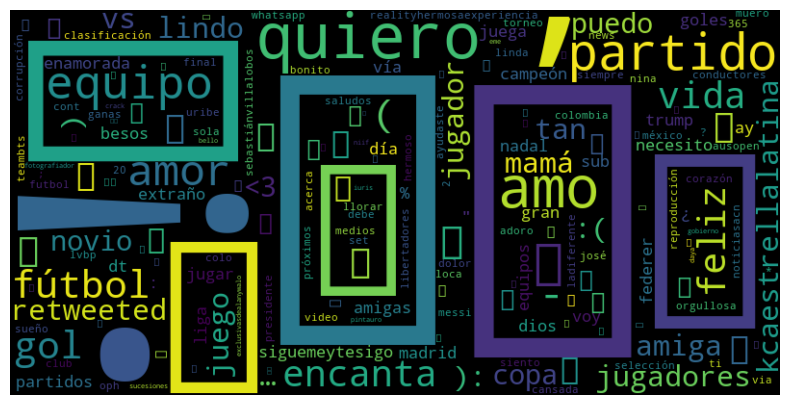

In [17]:

# Chi2
feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bow_train_frecuencia, y_train) # EL y_train son los paises 


dict_indices_invertido = {valor: key for key, valor in dict_indices.items()}
Logger.debug(f" Diccionario invertido de índices : {dict_indices_invertido}")

# Extraer las palabras seleccionadas
palabras_mejores_indices = feature_selector.get_support(indices=True)
palabras = [dict_indices_invertido[indice] for indice in palabras_mejores_indices]


# Extraer los scores
chi2_scores = feature_selector.scores_
best_scores = chi2_scores[palabras_mejores_indices] # type: ignore
Logger.debug(f" Puntajes Chi2 de las mejores palabras: {best_scores}")


# Distribución de k mejores palabras
distribucion_k_mejores_tweets = {palabra: score for palabra, score in zip(palabras, best_scores)}
mejores_50 = dict(sorted(distribucion_k_mejores_tweets.items(), key=lambda item: item[1], reverse=True)[:500])
Logger.debug(f"Frecuencia de palabras en tweets: {mejores_50}")


# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(mejores_50)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
